+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+
|               Time|X-Acceleration|Y-Acceleration|Z-Acceleration| X-Velocity| Y-Velocity| Z-Velocity|Composite-Acceleration|Composite-Velocity|Temperature Z|Temperature-XYZ|X-Velocity_predictions|
+-------------------+--------------+--------------+--------------+-----------+-----------+-----------+----------------------+------------------+-------------+---------------+----------------------+
|2022-12-01 12:00:00|    15.1796875|      16.15625|    10.4921875| 1.62109375|1.877929688|1.686523438|             17.515625|               3.0|        19.25|          19.25|                 1.621|
|2022-12-01 13:00:00|      16.09375|    15.3515625|     10.421875|1.466796875|1.686523438|1.462890625|               18.9375|          2.671875|        18.75|          18.75|                 1.467|
|2022-12-0

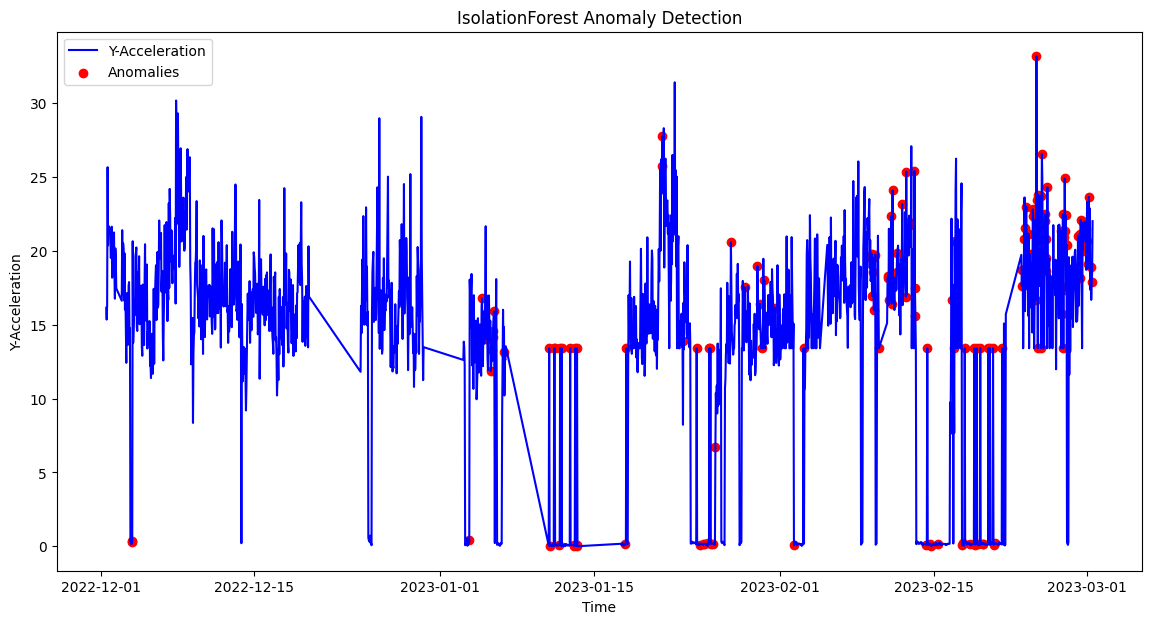

In [1]:
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Tạo Spark session
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

# Đọc file CSV
df = spark.read.csv("../../../data/Chiller.csv", header=True, inferSchema=True)
# Hiển thị dữ liệu
df.show()

# Chuyển đổi DataFrame của Spark thành Pandas DataFrame
pandas_df = df.toPandas()

# Lấy danh sách header và bỏ qua cột đầu tiên
columns = df.columns

# Chọn cột đầu tiên làm trục X (Timestamp) và một cột được chọn làm trục Y
timestamp_column = columns[0]
selected_column = "Y-Acceleration"  # Thay thế bằng tên cột bạn muốn chọn làm trục Y

# Chọn các cột cần thiết cho mô hình IsolationForest (bỏ qua cột đầu tiên)
features = pandas_df[columns[1:]].values

# Sử dụng IsolationForest để phát hiện bất thường
model = IsolationForest(contamination=0.1)  # Đặt mức độ bất thường mong muốn
model.fit(features)

# Dự đoán các điểm bất thường
predictions = model.predict(features)

# Thêm cột dự đoán vào DataFrame
pandas_df["anomaly"] = predictions

# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column, các điểm bất thường được đánh dấu bằng scatter màu đỏ
plt.figure(figsize=(14, 7))

# Vẽ biểu đồ line cho cột được chọn
plt.plot(pandas_df[timestamp_column], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == -1]
plt.scatter(anomalies[timestamp_column], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(timestamp_column)
plt.ylabel(selected_column)
plt.legend()
plt.title("IsolationForest Anomaly Detection")
plt.show()
